In [34]:
# Jade Chongsathapornpong, July 2023
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, KMeans

from larch.io import read_ascii
from larch.xafs import sort_xafs, pre_edge, autobk

# for convolution of FDMNES reference outputs
from larch.math import convolution1D

#%matplotlib nbagg

# Comparing averaged spectra: Normalization, PCA, Clustering
This plots averaged spectra from PyMCA. The goal is to compare the spectra, and identify which ones look "the same" via clustering.

In [35]:
### Zn K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# # This is everything to plot
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

# # This is what we want to fit the PCA to
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit',
#          'W37_ZnCo_RTInit',
#          'W39_HEO_RTInit',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

### Cu K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Cu_Kedge'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'CuO_Aldritch_RT']
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit',
#          'CuO_Aldritch_RT']

### Co K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Co_Kedge_Old'
names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
         'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
         'W35_Co_RTInit', 'W35_Co_RTFinal', 'W35_Co_900C',
         'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
         'W39_HEO_RTInit', 'W39_HEO_RTFinal',
         'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT'] #  'W39_HEO_900C' removed because it's too short?
names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
         'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
         'W35_Co_RTInit',
         'W37_ZnCo_RTInit',
         'W39_HEO_RTInit',
         'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT']

This next cell defines some utilities and my `larch` macros for normalization and background subtraction for the PCA workflow.

In [36]:
def interpolate_xas(in_energies, in_signal):
    """Args:
        - in_energies (list of array)
        - in_signal (list of array)
    Returns:
        - out_energies (array) a single array of energies interpolated to
        - out_signals (list of array) all the interpolated signals
    Uses the SHORTEST array in in_energies, and interpolates the remaining in_signal arrays to match it.
    """
    spectrum_lengths = [len(E) for E in in_energies]
    print("Lengths of spectra:", spectrum_lengths)
    shortest_idx = np.argmin(spectrum_lengths)
    print(f"Mapping to {len(in_energies[shortest_idx])} points from spectra up to {np.max(spectrum_lengths)} long")
    out_energies = in_energies[shortest_idx]
    out_signals = [np.interp(out_energies, energy, signal) for energy, signal in zip(in_energies, in_signal)]
    return out_energies, out_signals

def larch_load_chik(path, name, labels='energy_cenc, mu_fluo'):
    """Args:
        - path to csv file with labels, e.g. energy_cenc and mu_fluo (can be changed)
        - name to associate with the group
        - labels of columns to read
    Returns:
        - a Larch Group object with attributes initialized as done in xas_viewer
            according to the Larch buffer"""
    g = read_ascii(path, labels=labels)
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = 1000.*g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    g.norm_poly = 1.0 * g.norm
    autobk(g) # use defaults for auto-background-subtraction
    return g

def k_chik_from_names(names, kweight=2):
    """Args:
        - names (formatted as in the first cell)
    Returns:
        - ordered list of arrays of wavenumbers corresponding to:
        - ordered list of arrays of relative absorption (chi) weighted by k^kweight
    Uses interpolate_xas to map all signals down to one signal's wavenumbers
    """
    wavenumbers = []
    chiks = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load_chik(path, name)
        wavenumbers.append(lgrp.k)
        chiks.append(lgrp.chi * np.power(lgrp.k, kweight))
    return interpolate_xas(wavenumbers, chiks)

def E_mu_from_names(names):
    energies = []
    mus = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load_chik(path, name)
        energies.append(lgrp.energy)
        mus.append(lgrp.mu)
    return interpolate_xas(energies, mus)

Lengths of spectra: [251, 324, 251, 251, 250, 251, 251, 251, 323, 323, 324, 250, 251, 251, 251, 251, 250, 323, 276, 251, 324]
Mapping to 250 points from spectra up to 324 long
Lengths of spectra: [1400, 2198, 1398, 1399, 1398, 1398, 1399, 1398, 2198, 2198, 2198, 1468, 1398, 1398, 1398, 1398, 1398, 2198, 1708, 1398, 2198]
Mapping to 1398 points from spectra up to 2198 long


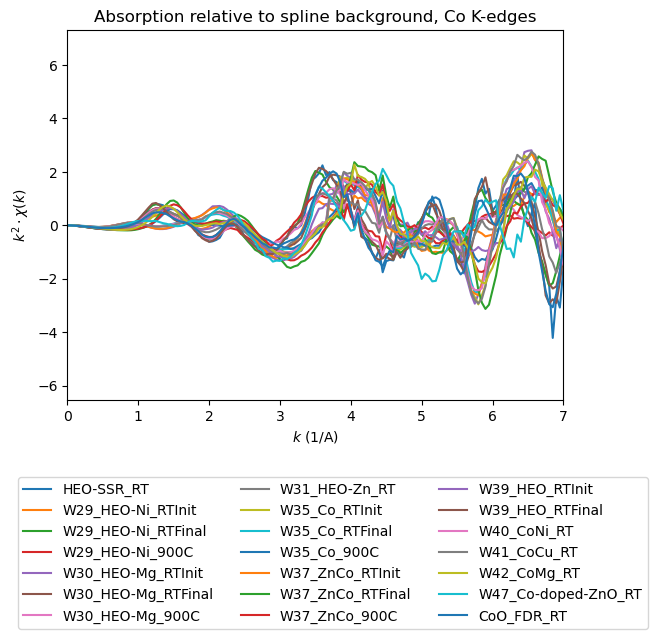

In [37]:
K, CHIK = k_chik_from_names(names_all)
E, MU = E_mu_from_names(names_all)
for i, chik in enumerate(CHIK):
    plt.plot(K, chik, label=names_all[i])
plt.title("Absorption relative to spline background, Co K-edges")

plt.xlim(0, 7)
plt.xlabel('$k$ (1/A)')
plt.ylabel('$k^2 \cdot \chi(k)$')
plt.legend(ncol=3, loc=(-0.1, -0.62))
# plt.savefig('Output/BM23/ChiK_Co')
plt.show()

## PCA and Unsupervised Clustering
To identify similar-looking EXAFS signals, I will try using some sort of clustering method, based on the PCA-decomposition of the $\chi(k)$.

Lengths of spectra: [251, 324, 250, 251, 323, 250, 251, 250, 323, 276, 251, 324]
Mapping to 250 points from spectra up to 324 long
[0.57820213 0.24677016 0.06027102 0.0421037  0.03067138 0.01179418]


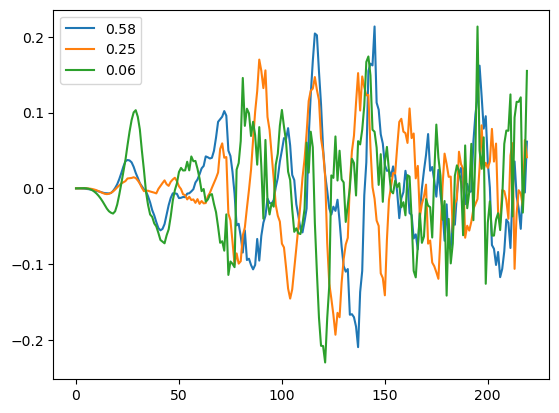

In [38]:
pca_start = 0
pca_end = 220 # which points to take for PCA (e.g. to crop out glitches/noisy regions)

# PCA expects (n_samples (each signal is a "sample"), n_features (data pts/signal))
_, weighted_chiks = k_chik_from_names(names_for_pca)

A = np.array([chik[pca_start:pca_end] for chik in weighted_chiks])

pca = PCA(n_components=6)
pca.fit(A)
print(pca.explained_variance_ratio_)
for i in range(3):
    plt.plot(pca.components_[i], label=f"{pca.explained_variance_ratio_[i]:.2f}")
# plt.xlim(150,600)
# plt.ylim(-0.15,0.15)
plt.legend()
# plt.savefig("Output/BM23/PC_Co_long", dpi=300)
plt.show()

# Save the principal components
# np.savetxt('Output/BM23/principalcomponents_Chik_Co.csv', pca.components_.transpose(), delimiter=',')

In [39]:
# reduced = pca.transform(np.array(delta_mus)) # apply PCA to all signals
reduced = pca.transform(np.array([c[pca_start:pca_end] for c in CHIK]))
print(f"{reduced.shape[0]} signals embedded in {reduced.shape[1]} dimensions.") 

# Save the PCA embeddings of each signal
# embedding_df = pd.DataFrame(reduced)
# embedding_df['sample'] = names_all
# embedding_df.to_csv('Output/BM23/pca_embeddings_chik_Co.csv')

# Perform clustering technique
ap = AffinityPropagation().fit(reduced)
# nc = 6
# km = KMeans(n_clusters=nc, n_init='auto').fit(reduced)

clusterings = {key: [] for key in np.unique(ap.labels_)}
for i, name in enumerate(names_all):
    clusterings[ap.labels_[i]].append((i, name))
    
print(clusterings)

21 signals embedded in 6 dimensions.
{0: [(3, 'W29_HEO-Ni_900C'), (6, 'W30_HEO-Mg_900C'), (7, 'W31_HEO-Zn_RT')], 1: [(4, 'W30_HEO-Mg_RTInit'), (8, 'W35_Co_RTInit'), (9, 'W35_Co_RTFinal'), (11, 'W37_ZnCo_RTInit'), (16, 'W40_CoNi_RT'), (17, 'W41_CoCu_RT')], 2: [(1, 'W29_HEO-Ni_RTInit'), (10, 'W35_Co_900C'), (12, 'W37_ZnCo_RTFinal'), (13, 'W37_ZnCo_900C'), (14, 'W39_HEO_RTInit'), (18, 'W42_CoMg_RT')], 3: [(0, 'HEO-SSR_RT'), (2, 'W29_HEO-Ni_RTFinal'), (5, 'W30_HEO-Mg_RTFinal'), (15, 'W39_HEO_RTFinal'), (20, 'CoO_FDR_RT')], 4: [(19, 'W47_Co-doped-ZnO_RT')]}


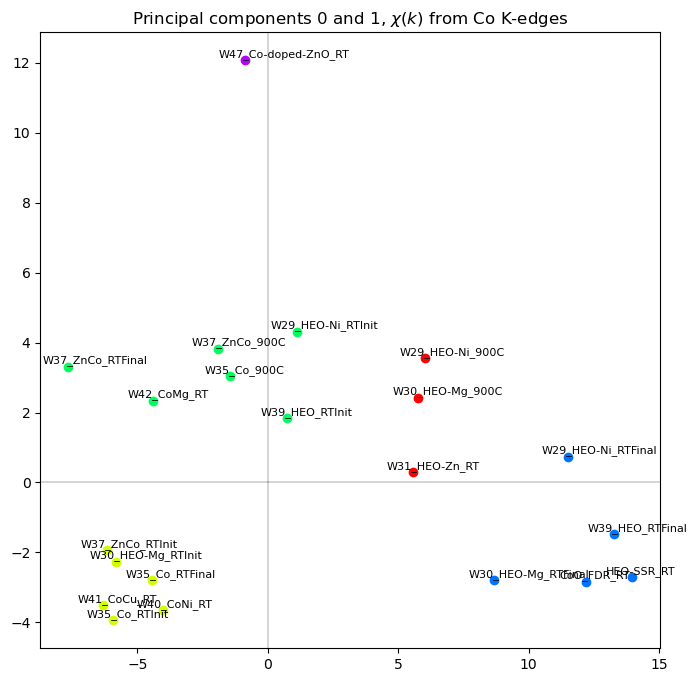

In [40]:
dim0 = 0 # 0, 1, 2, 3, 4, 5; dimensions of the PCA
dim1 = 1

adj_text_idx = ()#(13, 15) # indices into names_all for which to adjust text position

fig, ax = plt.subplots(figsize=(8,8))
for i, signalvec in enumerate(reduced):
    adj = 0.2 if i in adj_text_idx else 0.
    ax.axhline(0, linewidth=0.01, color='k')
    ax.axvline(0, linewidth=0.01, color='k')
    ax.plot(signalvec[dim0], signalvec[dim1], 'o', c=cm.hsv(ap.labels_[i]/(max(ap.labels_) + 1)))
    ax.text(signalvec[dim0]-1-adj, signalvec[dim1]+0.1+adj, names_all[i], fontsize=8)
ax.set_title(f"Principal components {dim0} and {dim1}, $\chi(k)$ from Co K-edges")
# plt.savefig(f"Output/BM23/Co_PCA/PCA_Co_Chik_long_{dim0}_{dim1}", dpi=300)
plt.show()

## Replotting the spectra that were clustered according to the PCA
I looked along dimensions 0, 1, and 2, and corroborated groupings between them. This could be automated using something like K-means or medoids.
I plotted things that are in the same clusters, and in far-separated clusters. I found the PCA overfits to temperature dependence, but is still useful.

In [ ]:
ref_root = r'FDMNES'
names_ref = ['CoO_Oh', 'Co15Zn85O_Co','Co3O4_Oh', 'Co3O4_Td']

kwt = 2
ref_scale = 0.7

clusternames = {0: 'R-Oh mix?', 1: 'Sp-Td,Oh', 2: 'R-Oh', 3: 'R-Oh / Sp-Td,Oh mix', 4: 'W-Td'}

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(1,7.22)
spec_offset = 0

# Plot experimental data
for key, members in clusterings.items():
    clustername = clusternames[key]
    ax.text(1.2, spec_offset+1.5, clustername, fontsize=8)
    for pair in members:
        index = pair[0]
        samplename = pair[1]
        chis = CHIK[index] + spec_offset
        ax.plot(K, chis, label=f'{samplename} {clustername}')
    spec_offset -= 4.5

ax.set_yticks([])
ax.set_xlabel('Wavenumber (1/A)')
ax.set_ylabel('$\chi(k)$ (arb)')
ax.set_title('Co K-edge fine structure clustered by PCA')
ax.legend(ncol=1, loc=(1.05, 0.08), fontsize=9)
plt.tight_layout()
# plt.savefig('Output/BM23/Co_ClusteredSpecs', dpi=300)
plt.show()

# Comparing to FDMNES simulations
Below I'll plot the spectra without background subtracted ($\mu$ instead of $\chi$), as the `larch` `autobk` seems to dislike the simulated spectra in my case.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
spec_offset = 0
edge_energy = 7712

# plot experiment
energy, mus = mu_from_names(names_all)
for key, members in clusterings.items():
    clustername = clusternames[key]
    ax.text(edge_energy + 70, spec_offset+0.35, clustername, fontsize=8)
    for pair in members:
        index = pair[0]
        samplename = pair[1]
        ax.plot(energy, mus[index] / np.max(mus[index]) + spec_offset, label=f'{samplename} {clustername}')
    spec_offset -= 1

# plot references
for name in names_ref:
    path = join(ref_root, name, name + '.txt')
    ax.text(edge_energy + 70, spec_offset+0.35, name, fontsize=8)
    data = np.genfromtxt(path, skip_header=5).transpose()
    E = data[0]
    mu = data[1] / np.max(data[1])
    mu_conv = convolution1D.conv(E, mu, np.array([2. for e in E]), e_cut=-4., kernel='lorentzian') # constant broadening w.r.t. energy
    ax.plot(data[0] + edge_energy, mu_conv / np.max(mu_conv) + spec_offset, label=name)
    spec_offset -= 1

plt.xlim(edge_energy - 10, edge_energy + 105)
plt.legend(ncol=1, loc=(1.05, 0.0), fontsize=8)
plt.tight_layout()
plt.savefig('Output/BM23/Co_withRef', dpi=300)
plt.show()